# Learning from an optimization perspective

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fsolve
import time as time

# 1. Algorithms

## 1.1 Dynamic programming

This is the classic DP algorithm

In [2]:
def dynamicProgramming(P,
                      r,
                      x_init,
                      nIter_max,
                      tolerance=10.0**(-14)
                      ):
    
    #this function will solve the Bellman Equation x = Px + r
    #using dynamic programming
    
    X=np.zeros((nIter_max+1,np.size(x_init)))
    x=x_init
    
    keep_going=True
    iter_count=0
    
    for k in range(1,nIter_max+1):
        
        if(keep_going):
            iter_count+=1
            x_new=P.dot(x)+r
            keep_going=np.max(np.abs(x_new-x))>tolerance
            x=x_new
        else:
            break
            
        X[k,:]=x
    
    X[range(iter_count+1,nIter_max+1),:]=x
    return iter_count, X

## 1.2 Gradient-based methods

I implemented four gradient-based methods :
* Gradient Descent with exact linesearch
* Gradient Descent with adaptive momentum, which can improve the performance of gradient descent, especially in narrow valleys
* Gradient Descent with adaptive moment estimation (ADAM). This algorithm is supposed to perform better than the former two. Although the initial behaviour is indeed nicer, after some iterations, ADAM seems to be stuck in some sort of cycling (see convergence plots at the end). This is probably caused by poor parameter tuning.
* Conjugate Gradient, which is among the most efficient algorithms for quadratic optimization

In [3]:
def gradientDescent(A,
                    b,
                    x_init,
                    nIter_max,
                    tolerance=10.0**(-14)
                   ):
    
    #this function will solve Ax=b by performing gradient descent
    #on the following quadratic problem : min ||Ax-b||^2
    
    #A is a matrix, not necessarily symetric
    #b is a vector
    #x_init is a vector
    #nIter_max is the maximum number of iterations of the algorithm
    
    X=np.zeros((nIter_max+1,np.size(x_init)))
    x=x_init
    
    keep_going=True
    iter_count=0
    
    for k in range(1,nIter_max+1):
        if(keep_going):
            
            iter_count+=1
            #compute current gradient
            g=A.T.dot(A.dot(x)-b)
            d=-g

            #compute exact linesearch
            q=A.dot(d)
            t= -q.T.dot(A.dot(x)-b) / q.T.dot(q)

            #update parameter vector
            x=x+t*d
            
            keep_going=np.max(np.abs(g))>tolerance
            
        X[k,:]=x
    
    X[range(iter_count+1,nIter_max+1),:]=x
    return iter_count, X

In [4]:
def gradientDescent_adaptiveMomentum(A,
                    b,
                    x_init,
                    nIter_max,
                    g_momentum=0.9,
                    eta=0.1,
                    tolerance=10.0**(-14)):
    
    #this function will solve Ax=b by performing gradient descent
    #on the following quadratic problem : min ||Ax-b||^2
    
    #A is a matrix, not necessarily symetric
    #b is a vector
    #x_init is a vector
    #nIter_max is the maximum number of iterations of the algorithm
    
    X=np.zeros((nIter_max+1,np.size(x_init)))
    
    x=x_init
    momentum=0.0*x
    keep_going=True
    iter_count=0
    
    for k in range(1,nIter_max+1):
        if(keep_going):
            iter_count+=1
            
            #compute current gradient
            g=A.T.dot(A.dot(x)-b)

            #update momentum
            momentum = g_momentum*momentum+ eta*g

            #update parameter vector
            x=x-momentum
            
            keep_going=np.linalg.norm(momentum)>tolerance
        else:
            break
            
        X[k,:]=x
    X[range(iter_count+1,nIter_max+1),:]=x
    return iter_count, X

In [5]:
def gradientDescent_ADAM(A,
                    b,
                    x_init,
                    nIter_max,
                    eta=0.01,
                    beta1=0.9,
                    beta2=0.99,
                    epsilon=10.0**(-8)):
    
    #this function will solve Ax=b by performing gradient descent
    #on the following quadratic problem : min ||Ax-b||^2
    
    #A is a matrix, not necessarily symetric
    #b is a vector
    #x_init is a vector
    #nIter_max is the maximum number of iterations of the algorithm
    
    X=np.zeros((nIter_max+1,np.size(x_init)))
    
    x=x_init
    m=0.0*x
    v=0.0*x
    
    m_hat=m
    v_hat=v
    
    beta1_k=beta1
    beta2_k=beta2
    
    iter_count=0
    
    for k in range(1,nIter_max+1):
        
        #update number of iterations
        iter_count+=1
        
        #compute current gradient
        g=A.T.dot(A.dot(x)-b)
        
        #update 
        m=beta1*m+(1-beta1)*g
        v=beta2*v+(1-beta2)*np.multiply(g,g)
        
        #correct the bias
        m_hat=m/(1.0-beta1_k)
        v_hat=v/(1.0-beta2_k)

        #update parameter vector
        x=x-eta*np.multiply( 1.0 / (np.sqrt(v_hat) + epsilon),m_hat)
        X[k,:]=x
        
        #update beta1_k and beta2_k
        beta1_k *= beta1
        beta2_k *= beta2
    
    X[range(iter_count+1,nIter_max+1),:]=x
    return iter_count, X

In [6]:
def conjugateGradient(A,
                    b,
                    x_init,
                    nIter_max,
                    epsilon_CG_a=10.0**(-14),
                    epsilon_CG_r=10.0**(-14)
                    ):
    
    #This function will solve Ax=b by minimizing the error function ||Ax-b||^2
    #The optimization method used is conjugate gradient
    
    X=np.zeros((nIter_max+1,np.size(x_init)))
    
    #initial parameters
    if(np.linalg.norm(x_init)==0):
        r=-A.T.dot(b)
    else:
        r=A.T.dot(A.dot(x_init)-b) #gradient at the initial point
        
    p=-r
    r_0_norm=np.linalg.norm(r)
    beta=0.0

    x=x_init
    
    keep_going=True
    iter_count=0
    
    for k in range(1,nIter_max+1):
        r_sqnorm=r.dot(r)
        keep_going=(np.sqrt(r_sqnorm) > epsilon_CG_a+epsilon_CG_r*r_0_norm)
        
        #keep updating while stopping criterion is not met
        if(keep_going):
            iter_count+=1
            
            q=A.dot(p) #this speeds up things a bit
            
            #compute step size
            alpha = r_sqnorm / q.T.dot(q)

            #perform update on x
            x+=alpha*p

            #compute new conjugate gradient 
            r+= alpha*A.T.dot(q)
            beta= r.dot(r)/ r_sqnorm
            p= - r+beta*p
        else:
            break

        X[k,:]=x
    
    X[range(iter_count+1,nIter_max+1),:]=x
    
    return iter_count, X

# 2. An analysis of (expected) TD-Learning

In the following, I analyse the expected behaviour of Temporal Difference Learning. I show that TD learning can be re-written as a convex, quadratic optimization problem. I implemented a few optimization algorithms, including conjugate gradient, which is highly efficient for quadratic optimization. Conjugate gradient can also be extended to the non-linear case.

One big question that remains unanswered : how does Conjugate Gradient perform in a stochastic setting ? I found very little litterature related to Stochastic Conjugate Gradient, so I have no idea as to what the answer is.

## 2.1 Define the environment

We study the 1000-steps random walk (ex 9.1 in Sutton's book).

The discounting factor is $\gamma$, and $\pi$ is the policy to be evaluated.

Denote $d$ the stationnaty distribution of states under $\pi$. We define $D$ as the diagonal matrix which diagonal entries are $d$ :

$$
D = 
\left(
\begin{array}{ccc}
d(s_{1}) & & 0\\
& \ddots & \\
0 & & d(s_{|\mathcal{S}|})
\end{array}
\right)
$$

By definition of $d$, we have $d^{T} = d^{T} P$, or $d = P^{T} d$. That is, $d$ is an eigenvector of $P^{T}$ associated to eigenvalue $1$.

In [7]:
class Random_walk:
    
    def __init__(self, nState, nStep, nFeatures, d_init,gamma,approx=True):
        
        #discount factor
        self.gamma=gamma
        
        #number of states
        self.nState=nState
        self.nStep=nStep
        
        #transition matrix and reward vector
        self.P_pi = np.zeros((nState+1,nState+1))
        self.r_pi=np.zeros(nState+1)
        self.compute_MDP()
        
        #initial state distribution
        self.d_init=d_init
        self.d_stationnary=self.d_init
        self.compute_stationnary_distribution()
        
        #features
        self.nFeatures=nFeatures
        self.Phi=np.eye(nState+1)
        if(approx):
            self.create_features() 
        
        #Bellman matrix and vector
        self.P_bellman=self.gamma*self.P_pi
        self.r_bellman=self.r_pi
        
        #A matrix and b vector
        I=np.eye(nState+1)
        self.A_exact=I-self.P_bellman
        self.b_exact=self.r_bellman
        
        if(approx):
            D=np.diag(self.d_stationnary)
            self.A_approx=(self.Phi).T.dot(D).dot(I-self.P_bellman).dot(self.Phi)
            self.b_approx=(self.Phi).T.dot(D).dot(self.r_bellman)
            
        #finally, initialize value function
        self.v_pi=np.zeros(nState+1)
        self.theta=np.zeros(nFeatures+1)
        
    def compute_MDP(self):
        """Compute transition matrix and reward vector for the random walk MDP"""

        #Policy is defined as follow:
        #at each time step, go left or right with 50% prob, and take 1 to nStep steps in that direction (with equal probability)

        #first, we compute the transition matrix P_pi
        #note that for large values of nState, this can be computationnaly and emmory intensive intensive
        #sparse matrices should probably be used here

        rows, cols = np.indices((nState+1,nState+1))

        for i in range(1,nStep+1):
            row_vals_up = np.diag(rows, k=i)
            col_vals_up = np.diag(cols, k=i)
            row_vals_dw = np.diag(rows, k=-i)
            col_vals_dw = np.diag(cols, k=-i)
            self.P_pi[row_vals_up,col_vals_up]+=(1.0/(nStep*2.0)) * np.ones(nState+1-i)
            self.P_pi[row_vals_dw,col_vals_dw]+=(1.0/(nStep*2.0)) * np.ones(nState+1-i)

        #state 0 is terminal, so we need to correct the corresponding values in P_pi
        self.P_pi[0,:]=0
        self.P_pi[:,0]=0
        self.P_pi[0,0]=1

        #If the agent hits the boundaries, they reach the terminal state
        #Here we correct the value of P_pi for states are are close to the boundaries
        self.P_pi[np.arange(1,nStep+1),0]=0.5-np.arange(0,nStep)/(2.0*nStep)
        self.P_pi[range(nState+1-nStep,nState+1),0]=0.5-np.arange(nStep-1,-1,step=-1)/(2.0*nStep)

        #Now, we compute the expected reward vector, r_pi
        #The reward is +1 if reach right end, -1 if reach left end, 0 otherwise
        self.r_pi[range(1,nStep+1)]=-(0.5-np.arange(0,nStep)/(2.0*nStep))
        self.r_pi[range(nState+1-nStep,nState+1)]=0.5-np.arange(nStep-1,-1,step=-1)/(2.0*nStep)

        return

    def create_features(self):
        """Compute features matrix"""
        
        #Compute the feature matrix by aggregating states
        self.Phi=np.vstack((np.zeros(self.nFeatures),np.kron(np.eye(self.nFeatures),np.ones((nState/self.nFeatures,1)))))
        u=np.zeros(nState+1).reshape((nState+1,1))
        u[0]=1
        self.Phi=np.hstack((u,self.Phi))

        return 

    def compute_stationnary_distribution(self,nIter=1000):
        """Compute the stationnary distribution of the MDP"""

        #tweak the transition matrix, otherwise all the mass goes to the terminal state
        self.P_pi[0,:]=self.d_init
        self.d_=self.d_init

        #a 100 iterations will usually yield good results
        #
        for i in range(nIter):
            self.d_stationnary=(self.P_pi).T.dot(self.d_stationnary)

        #cancel modifications
        self.P_pi[0,:]=0
        self.P_pi[0,0]=1

        return
    
    def compute_valueFunction_exact(self,algo,nIter_max,verbose=False):
        
        v_init=np.zeros(self.nState+1)
        v_history=np.zeros(self.nState+1)
        
        nIter=0
        
        start_=time.time()
        
        if(algo=='DP'):
            #dynamic programming
            nIter, v_history=dynamicProgramming(self.P_bellman,self.r_bellman,v_init,nIter_max)
            
        elif(algo=='GD'):
            #gradient descent with exact linesearch
            nIter, v_history=gradientDescent(self.A_exact,self.b_exact,v_init,nIter_max)
            
        elif(algo=='GD_am'):
            #gradient descent with adaptive momentum, default parameters
            nIter, v_history=gradientDescent_adaptiveMomentum(self.A_exact,self.b_exact,v_init,nIter_max)
            
        elif(algo=='GD_ADAM'):
            #gradient descent, ADAM
            nIter, v_history=gradientDescent_ADAM(self.A_exact,self.b_exact,v_init,nIter_max)
            
        elif(algo=='CG'):
            #conjugate gradient
            nIter, v_history=conjugateGradient(self.A_exact,self.b_exact,v_init,nIter_max)
        
        end_ = time.time()
        
        if(verbose):
            print 'Algo:',algo,'\t | Time (s):',end_-start_, '\t | #Iter:', nIter, '\t | T/iter:', (end_-start_)/nIter
        
        return v_history
    
    def compute_valueFunction_approx(self,algo,nIter_max,verbose=False,alpha=1.0):
        
        theta_init=np.zeros(self.nFeatures+1)
        theta_init=self.theta+0.0001*np.random.rand(self.nFeatures+1)
        theta_history=np.zeros(self.nFeatures+1)
        nIter=0
        
        start_=time.time()
        
        if(algo=='DP'):
            #dynamic programming
            nIter, theta_history=dynamicProgramming(np.eye(self.nFeatures+1)-alpha*self.A_approx,alpha*self.b_approx,theta_init,nIter_max)
            
        elif(algo=='GD'):
            #gradient descent with exact linesearch
            nIter, theta_history=gradientDescent(self.A_approx,self.b_approx,theta_init,nIter_max)
            
        elif(algo=='GD_am'):
            #gradient descent with adaptive momentum, default parameters
            nIter, theta_history=gradientDescent_adaptiveMomentum(self.A_approx,self.b_approx,theta_init,nIter_max,0.8,0.1)
            
        elif(algo=='GD_ADAM'):
            #gradient descent, ADAM
            nIter, theta_history=gradientDescent_ADAM(self.A_approx,self.b_approx,theta_init,nIter_max)
            
        elif(algo=='CG'):
            #conjugate gradient
            nIter, theta_history=conjugateGradient(self.A_approx,self.b_approx,theta_init,nIter_max)
        
        end_ = time.time()
        
        if(verbose):
            print 'Algo:',algo,'\t | Time (s):',end_-start_, '\t | #Iter:', nIter, '\t | T/iter:', (end_-start_)/nIter
        
        return theta_history

In [8]:
nState=1000
nStep=100
nFeatures=20
gamma=0.9

d_init=(1.0/nState)*np.ones(nState+1)
d_init[0]=0.0
problem=Random_walk(nState,nStep,nFeatures,d_init,gamma)

## 2.2 Tabular representation

### 2.2.1 Dynamic Programming

Consider the following Bellman equation, which solution is denoted $v^{*}$ :
$$
v = r + P v = (I-P)^{-1} r
$$

This can be solved iteratively with dynamic programming (DP) :
\begin{align*}
v_{0} &= 0\\
v_{k+1} &= r + P v_{k}
\end{align*}

Assuming $\rho(P)<1$, where $\rho(P)$ denotes the spectral radius of $P$, then DP converges linearly at rate $\rho(P)$.

### 2.2.2 Gradient-based methods

Dynamic Programming is about iteratively computing the unique fixed point of the Bellman operator, eventually solving the Bellman equation:
$$
v = r + Pv
$$

Denote $A=I-P$, then the Bellman equation also writes as a linear system:
$$
Av = r
$$

Instead of seeing the Bellman equation as a fixed point, one can see it as solving the following quadratic program: 
$$
\min_{v} \frac{1}{2} ||A v - r||^{2}
$$
which is guaranteed to have a unique solution. 

Expanding the squared norm, we get:
$$
\boxed{\ \ \
\large{
\min_{v} \frac{1}{2} v^{T} A^{T} A v - (A^{T} r)^{T} v
}
\ \ \ }
$$

Here, we are dealing with an unconstrained, convex quadratic program, which we can solve using our favourite algorithm. Besides, convergence does not rely on the spectral radius of $P$ anymore.

In [9]:
#First, compute value function in the tabular case
nIter=1000
v_DP_history=problem.compute_valueFunction_exact('DP',nIter,True)
v_GD_history=problem.compute_valueFunction_exact('GD',nIter,True)
v_GD_am_history=problem.compute_valueFunction_exact('GD_am',nIter,True)
v_GD_ADAM_history=problem.compute_valueFunction_exact('GD_ADAM',nIter,True)
v_CG_history=problem.compute_valueFunction_exact('CG',nIter,True)

#To compute the errors, we need to know the true value of v_TD
#Any method can be used, here we just take the value returned by CG
v_TD = np.linalg.inv(problem.A_exact).dot(problem.b_exact)
problem.v_pi=v_TD

#Now, compute errors
err_DP = np.max(np.abs(v_DP_history-v_TD),1)
err_GD = np.max(np.abs(v_GD_history-v_TD),1)
err_GD_am = np.max(np.abs(v_GD_am_history-v_TD),1)
err_GD_ADAM = np.max(np.abs(v_GD_ADAM_history-v_TD),1)
err_CG = np.max(np.abs(v_CG_history-v_TD),1)

Algo: DP 	 | Time (s): 0.0369999408722 	 | #Iter: 176 	 | T/iter: 0.000210226936774
Algo: GD 	 | Time (s): 0.72000002861 	 | #Iter: 1000 	 | T/iter: 0.00072000002861
Algo: GD_am 	 | Time (s): 0.351000070572 	 | #Iter: 902 	 | T/iter: 0.000389135333228
Algo: GD_ADAM 	 | Time (s): 0.392999887466 	 | #Iter: 1000 	 | T/iter: 0.000392999887466
Algo: CG 	 | Time (s): 0.010999917984 	 | #Iter: 23 	 | T/iter: 0.000478257303653


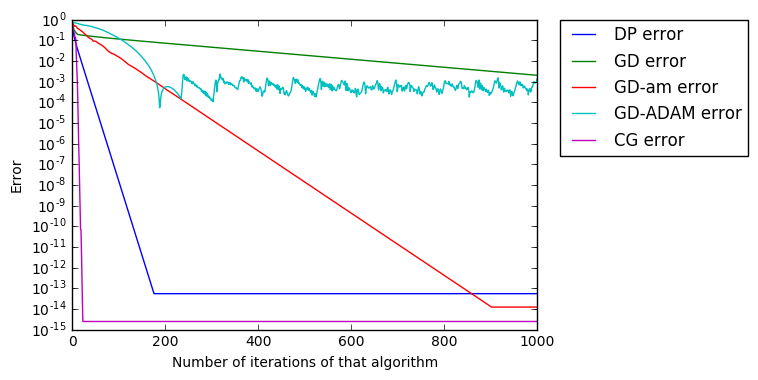

In [10]:
#plot the learning curves
plt.semilogy(err_DP,label='DP error')
plt.semilogy(err_GD,label='GD error')
plt.semilogy(err_GD_am,label='GD-am error')
plt.semilogy(err_GD_ADAM,label='GD-ADAM error')
plt.semilogy(err_CG,label='CG error')

plt.xlabel('Number of iterations of that algorithm')
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.3 Linear approximation

We now consider the case of linear function approximation. We denote $\Phi$ the feature matrix, which we assume has full column rank. We have seen previously that the TD fixed point writes as :
$$
A \theta_{TD} = b
$$

with :
\begin{align}
A &= \Phi^{T}  D \cdot \big( I-P\big) \cdot \Phi\\
b &= \Phi^{T}  D \cdot r \\
\end{align}

We then derive the projected Bellman equation :
$$
\theta_{TD} = (I-A) \theta_{TD} + b
$$

### 2.3.1 Approximate DP

In approximate DP, we try to solve the Bellman equation using a linear approximation, or equivalently, we try to solve the projected Bellman equation :

$$
\theta_{TD} = (I-A) \theta_{TD} + b
$$
and DP will converge if the spectral radius of $I-A$ is less than one. 

In practice (eg $TD(\lambda)$), although $A$ is usually positive definite, we have no information on its spectral radius. Therefore, we introduce a learning rate $\alpha$ to ensure convergence, which yields :

$$
\theta_{TD} = (I-\alpha A) \theta_{TD} + \alpha b
$$

Note that if $\lambda \in Sp(A)$, then $1-\alpha \lambda \in Sp(I-\alpha A)$. Therefore, assuming all eigenvalues of $A$ have positive real parts, it is easy to show the following :
$$
\rho(I-\alpha A) < 1 \Leftrightarrow \alpha < \frac{2}{\rho(A)}
$$
which ensures convergence of approximate DP when satisfied.

However, as soon as $A$ has an eigenvalue with negative real part, then $\rho(I-\alpha A)>1$, no matter how small (but still positive) we choose $\alpha$.

##### Remark : link to divergence in the off-policy case
I haven't been able to formally prove it but I have the intuition that, in the off-policy case, introducing importance ratios leads to a matrix $A$ with at least one negative eigenvalue. If this conjecture is true, then we should be able to show that if the behaviour policy is sufficiently close to the target policy, TD remains convergent.

### 2.3.2 Gradient-based methods

We now do the sane as before, ie see the TD fixed-point as the solution of the linear system :
$$
A \theta_{TD} = b
$$

I now show that GTD and GTD2/TDC are actually solving this linear system, but using different preconditionners.

* First, we write the TD fixed point as :
$$
A^{T} A \theta_{TD} = A^{T} b
$$
which means $\theta_{TD}$ is a minimizer of $J_{1}(\theta)$, where :
\begin{align*}
J_{1}(\theta) &= \theta^{T} A^{T} A \theta - 2 (A^{T}b)^{T} + b^{T} A^{T} A b\\
&= (A\theta - b)^{T} (A\theta - b)\\
&= (\Phi^{T} D (I-P) \Phi \theta - \Phi^{T} D r)^{T} (\Phi^{T} D (I-P) \Phi \theta - \Phi^{T} D r)\\
&= \mathbb{E}[\delta \phi]^{T} \mathbb{E}[\delta \phi]\\
&= NEU(\theta)
\end{align*}
We get the GTD algorithm!

* Now, let us re-write the fixed-point as :
$$
A^{T} (\Phi^{T} D \Phi)^{-1} A \theta_{TD} = A^{T} (\Phi^{T} D \Phi)^{-1} b
$$
which means that $\theta_{TD}$ is a minimizer of $J_{2}(\theta)$, where :
\begin{align*}
J_{2}(\theta) &= \theta^{T} (\Phi^{T} D \Phi)^{-1} A^{T} A \theta - 2 (A^{T} (\Phi^{T} D \Phi)^{-1} b)^{T} + b^{T} A^{T} (\Phi^{T} D \Phi)^{-1} A b\\
&= (A\theta - b)^{T} (\Phi^{T} D \Phi)^{-1} (A\theta - b)\\
&= (\Phi^{T} D (I-P) \Phi \theta - \Phi^{T} D r)^{T} (\Phi^{T} D \Phi)^{-1} (\Phi^{T} D (I-P) \Phi \theta - \Phi^{T} D r)\\
&= \mathbb{E}[\delta \phi]^{T} \mathbb{E}[\phi^{T} \phi]^{-1} \mathbb{E}[\delta \phi]\\
&= MSPBE(\theta)
\end{align*}
we get GTD2 and TDC algorithms!

This illustrates the close relation between GTD and GTD2/TDC. Both solve the same linear system $A \theta = b$, but do so by using different preconditionners. Furthermore, the convergence of these algorithms does not rely on the spectral radius of $A$, which probably explains why they do not diverge in in the off-policy case.

In [11]:
#First, compute the optimal parameter vector, theta
nIter=1000
theta_DP_history=problem.compute_valueFunction_approx('DP',nIter,True, alpha=1.0)
theta_GD_history=problem.compute_valueFunction_approx('GD',nIter,True)
theta_GD_am_history=problem.compute_valueFunction_approx('GD_am',nIter,True)
theta_GD_ADAM_history=problem.compute_valueFunction_approx('GD_ADAM',nIter,True)
theta_CG_history=problem.compute_valueFunction_approx('CG',nIter,True)

#deduce the approximated value function
v_DP_history=((problem.Phi).dot(theta_DP_history.T)).T
v_GD_history=((problem.Phi).dot(theta_GD_history.T)).T
v_GD_am_history=((problem.Phi).dot(theta_GD_am_history.T)).T
v_GD_ADAM_history=((problem.Phi).dot(theta_GD_ADAM_history.T)).T
v_CG_history=((problem.Phi).dot(theta_CG_history.T)).T

#To compute the errors, we need to know the true value of v_TD
#Any method can be used, here we just take the value returned by CG
theta_TD = np.linalg.inv(problem.A_approx).dot(problem.b_approx)
v_TD = (problem.Phi).dot(theta_TD)
problem.theta=theta_TD

#Now, compute errors
err_DP = np.max(np.abs(v_DP_history-v_TD),1)
err_GD = np.max(np.abs(v_GD_history-v_TD),1)
err_GD_am = np.max(np.abs(v_GD_am_history-v_TD),1)
err_GD_ADAM = np.max(np.abs(v_GD_ADAM_history-v_TD),1)
err_CG = np.max(np.abs(v_CG_history-v_TD),1)

Algo: DP 	 | Time (s): 0.00600004196167 	 | #Iter: 1000 	 | T/iter: 6.00004196167e-06
Algo: GD 	 | Time (s): 0.010999917984 	 | #Iter: 1000 	 | T/iter: 1.0999917984e-05
Algo: GD_am 	 | Time (s): 0.0090000629425 	 | #Iter: 1000 	 | T/iter: 9.0000629425e-06
Algo: GD_ADAM 	 | Time (s): 0.010999917984 	 | #Iter: 1000 	 | T/iter: 1.0999917984e-05
Algo: CG 	 | Time (s): 0.0 	 | #Iter: 25 	 | T/iter: 0.0


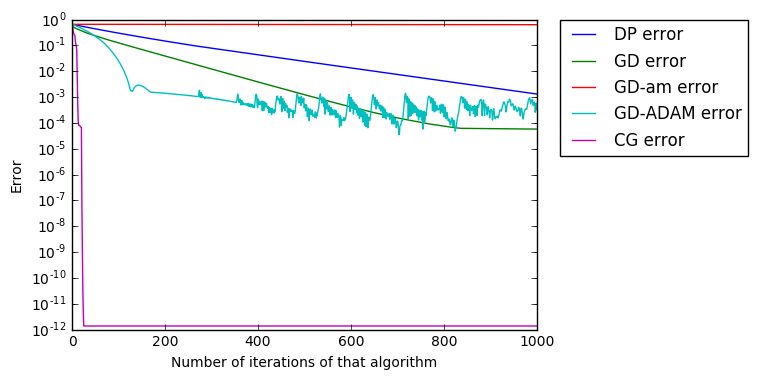

In [12]:
#plot the learning curves
plt.semilogy(err_DP,label='DP error')
plt.semilogy(err_GD,label='GD error')
plt.semilogy(err_GD_am,label='GD-am error')
plt.semilogy(err_GD_ADAM,label='GD-ADAM error')
plt.semilogy(err_CG,label='CG error')

plt.xlabel('Number of iterations of that algorithm')
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()